In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.metrics import root_mean_squared_error

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from permetrics.regression import RegressionMetric

from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Product, Sum, WhiteKernel
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.utils.data import DataLoader,TensorDataset, Dataset, random_split

import math
import random, os

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)


In [3]:
#plot & errors
def plot_peak_comparison(y_actual, y_pred, sample_idx):
    plt.figure(figsize=(8, 4))
    plt.plot(y_actual[sample_idx], label="Actual", marker="o")
    plt.plot(y_pred[sample_idx], label="Predicted", marker="x")
    plt.axvline(np.argmax(y_actual[sample_idx]), color="blue", linestyle="--", label="Actual Peak Day")
    plt.axvline(np.argmax(y_pred[sample_idx]), color="red", linestyle="--", label="Predicted Peak Day")
    plt.title(f"Peak Day and Height Comparison (Sample {sample_idx})")
    plt.xlabel("Days")
    plt.ylabel("Infected Count")
    plt.legend()
    plt.show()
def plot_actual_vs_predicted(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    for i in range(3): 
        plt.plot(y_test.iloc[i, :].values, label=f'Actual (Sample {i+1})', marker='o')
        plt.plot(y_pred[i, :], label=f'Predicted (Sample {i+1})', linestyle='--')
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Infected Count')
    plt.legend()
    plt.grid()
    plt.show()
def plot_actual_vs_predicted( y_pred, y_test, title):
    plt.figure(figsize=(12, 6))
    for i in range(3):  
        plt.plot(y_test.iloc[i, :].values, label=f'Actual (Sample {i+1})', marker='o')
        plt.plot(y_pred[i, :], label=f'Predicted (Sample {i+1})', linestyle='--')
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Infected Count')
    plt.legend()
    plt.grid()
    plt.show()
def evalution1(A,F):
    evaluator = RegressionMetric(A, F)
    print("MAE",evaluator.MAE(multi_output="raw_values"))
    #print("NRMSE",evaluator.NRMSE(multi_output="raw_values"))
    print("RMSE",evaluator.RMSE(multi_output="raw_values"))
def evalution2(A,F):
    evaluator = RegressionMetric(A, F)
    print("mae",evaluator.MAE(multi_output="raw_values").mean())
    #print("nrmse",evaluator.NRMSE(multi_output="raw_values").mean())
    print("rmse",evaluator.RMSE(multi_output="raw_values").mean())
def evalution3(A,F):
    evaluator = RegressionMetric(A, F)
    return evaluator.MAE(multi_output="raw_values"),evaluator.RMSE(multi_output="raw_values")#,evaluator.NRMSE(multi_output="raw_values")
def peak_day_classification_accuracy(y_actual, y_pred):
    actual_peak_day = np.argmax(y_actual, axis=1)
    predicted_peak_day = np.argmax(y_pred, axis=1)
    return np.mean(actual_peak_day == predicted_peak_day)
def peak_height_mae(y_actual, y_pred):
    actual_peak_height = np.max(y_actual, axis=1)
    predicted_peak_height = np.max(y_pred, axis=1)
    return np.mean(np.abs(predicted_peak_height - actual_peak_height))

In [5]:
df = pd.read_csv('../data/network_model_dataset_7200.csv', index_col=0)
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[[str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(round(df['beta'].min(), 2), 
                                                                  round(df['beta'].max(), 2),
                                                                  round(df['alpha'].min(), 2),
                                                                  round(df['alpha'].max(), 2)))

X = data[['alpha', 'beta']]
y = data['ts']

Диапазон параметров beta:[0.1, 0.99], alpha:[0.2, 0.99]


In [6]:
#data shape prepare for basic ml
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_y = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()# scaler_y.fit_transform(y_train)
y_test_scaled = y_test.copy().to_numpy()#scaler_y.transform(y_test)
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
known_seq_train=y_train[[1,2,3,4,5]]
known_seq_test=y_test[[1,2,3,4,5]]
#data shape prepare for sequence to sequence
X_train_seq=torch.cat([torch.tensor(X_train_scaled, dtype=torch.float32),torch.tensor(known_seq_train.to_numpy(), dtype=torch.float32) ], dim=1)
X_test_seq=torch.cat([torch.tensor(X_test_scaled, dtype=torch.float32),torch.tensor(known_seq_test.to_numpy(), dtype=torch.float32)  ], dim=1)
y_test_seq = torch.tensor(y_test_scaled, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_scaled, dtype=torch.float32)


KeyError: "None of [Index([1, 2, 3, 4, 5], dtype='int64')] are in the [index]"

In [9]:
#RBF
scaler_y = MinMaxScaler()
y_train_rbf =scaler_y.fit_transform(y_train_scaled)
y_test_rbf = y_test_scaled.copy()

kernel_rbf = RBF(length_scale=1.0,length_scale_bounds=np.array([[1e-11, 1e+1]]))
kernel_rq = RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel1  = Sum(kernel_rbf, kernel_rq)
kernel2  = Sum(kernel_rbf, kernel_rq)+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 10e10))
#RBF1=GaussianProcessRegressor(kernel=kernel1)#, normalize_y=True
RBF2=GaussianProcessRegressor(kernel=kernel2)
#RBF1.fit(X_train_scaled, y_train_scaled)
print("#####################################################################")
RBF2.fit(X_train_scaled, y_train_rbf)
y_pred_test_rbf2 = RBF2.predict(X_test_scaled)
y_pred_test_rbf2 = scaler_y.inverse_transform(y_pred_test_rbf2)

#####################################################################


In [15]:
#my model
def test2(actual, pred):
    rmse_sum = []
    for (y_t, y_p) in zip(actual, pred):
        rmse_sum.append(root_mean_squared_error(y_t,y_p ))
    print(f"RMSE: {np.array(rmse_sum).mean()}")
mae, rmse = [], []
for y_t, x_t in zip(y_test_rbf, y_pred_test_rbf2):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))



In [17]:
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])


,mean,std,min,25%,50%,75%,max
mae,30.656808,37.554689,2.505981,10.595477,15.176586,37.247623,188.379745


In [19]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,78.791399,94.595535,5.200765,27.151724,38.276682,92.678654,460.393189


In [21]:
#rf
scaler_y = MinMaxScaler()
y_train_rf =scaler_y.fit_transform(y_train_scaled)
y_test_rf = y_test_scaled.copy()
rf_params = {'n_estimators': [160], 
             'min_samples_split': [2], 
             'min_samples_leaf': [4],
             'max_features': ['log2'], 
             'max_depth': [10],
             'bootstrap': [True]}
rf1 = RandomForestRegressor(random_state=42)
rf_grid1 = GridSearchCV(rf1, rf_params, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid1.fit(X_train_scaled, y_train_rf)
print(f"Best Random Forest Params: {rf_grid1.best_params_}")
best_rf1=rf_grid1.best_estimator_
##multioutput
rf_params = {'estimator__n_estimators': [144], 
             'estimator__min_samples_split': [2], 
             'estimator__min_samples_leaf': [4],
             'estimator__max_features': ['log2'], 
             'estimator__max_depth': [10],
             'estimator__bootstrap': [True]}
rf2 = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_grid2 = GridSearchCV(rf2, rf_params, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid2.fit(X_train_scaled, y_train_rf)
print(f"Best Random Forest Params: {rf_grid2.best_params_}")
best_rf2=rf_grid2.best_estimator_
#sequence regression
rf_params = {'n_estimators': [ 180], 
             'min_samples_split': [2], 
             'min_samples_leaf': [4],
             'max_features': ['log2'], 
             'max_depth': [10],
             'bootstrap': [True]}
rf3=RegressorChain(RandomForestRegressor(random_state=42))
rf_grid3 = GridSearchCV(
        estimator=rf3, 
        param_grid={'base_estimator__' + k: v for k, v in rf_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
rf_grid3.fit(X_train_scaled, y_train_rf)
print(f"Best Random Forest Params: {rf_grid3.best_params_}")
best_rf3=rf_grid3.best_estimator_
y_pred_rf1 = best_rf1.predict(X_test_scaled)
y_pred_rf2 = best_rf2.predict(X_test_scaled)
y_pred_rf3 = best_rf3.predict(X_test_scaled)
y_pred_rf1 = scaler_y.inverse_transform(y_pred_rf1)
y_pred_rf2 = scaler_y.inverse_transform(y_pred_rf2)
y_pred_rf3 = scaler_y.inverse_transform(y_pred_rf3)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Params: {'estimator__bootstrap': True, 'estimator__max_depth': 10, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 144}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Params: {'base_estimator__bootstrap': True, 'base_estimator__max_depth': 10, 'base_estimator__max_features': 'log2', 'base_estimator__min_samples_leaf': 4, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 180}


In [25]:
y_pred_rf1[y_pred_rf1 <0] = 0
y_pred_rf2[y_pred_rf2 <0] = 0
y_pred_rf3[y_pred_rf3 <0] = 0

In [27]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rf, y_pred_rf1):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))


df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,32.439617,33.42856,3.050849,12.254233,18.184128,36.971273,158.792639


In [29]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,87.295419,83.705732,7.324891,38.570262,54.736218,104.849038,368.913332


In [31]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rf, y_pred_rf2):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))


df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,32.413591,34.376931,5.209941,13.541696,20.928226,38.24979,171.599333


In [33]:

df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,87.411177,86.205342,12.786777,33.828886,61.949162,93.130979,413.68265


In [35]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rf, y_pred_rf3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))


df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])


,mean,std,min,25%,50%,75%,max
mae,32.768161,42.158655,2.486193,12.686447,18.466193,29.9598,214.533169


In [37]:


df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,87.875795,106.318541,5.415696,30.173155,51.475285,91.553631,535.336065


In [39]:
#linear
scaler_y = MinMaxScaler()
y_train_l =scaler_y.fit_transform(y_train_scaled)
y_test_l = y_test_scaled.copy()

linear_model = LinearRegression()
multioutput_linear = MultiOutputRegressor(linear_model)
chain_linear = RegressorChain(linear_model)

multioutput_linear.fit(X_train_scaled, y_train_l)
chain_linear.fit(X_train_scaled, y_train_l)

y_pred_multioutput_linear = multioutput_linear.predict(X_test_scaled)
y_pred_chain_linear = chain_linear.predict(X_test_scaled)
y_pred_multioutput_linear = scaler_y.inverse_transform(y_pred_multioutput_linear)
y_pred_chain_linear = scaler_y.inverse_transform(y_pred_chain_linear)
y_pred_multioutput_linear[y_pred_multioutput_linear <0] = 0
y_pred_chain_linear[y_pred_chain_linear <0] = 0

In [43]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_l, y_pred_multioutput_linear):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,30.797355,37.697697,3.603977,9.614738,16.590252,32.821253,184.101404


In [45]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,80.313223,96.211734,7.36413,20.16683,52.33628,83.705215,457.725288


In [47]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_l, y_pred_chain_linear):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,30.797355,37.697697,3.603977,9.614738,16.590252,32.821253,184.101404


In [49]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,80.313223,96.211734,7.36413,20.16683,52.33628,83.705215,457.725288


In [51]:
#xgb
scaler_y = MinMaxScaler()
y_train_xgb =scaler_y.fit_transform(y_train_scaled)
y_test_xgb = y_test_scaled.copy()

XGB_params = {'n_estimators': [450],
               'max_depth': [100],
               'subsample':[0.8],
               'learning_rate': [0.01]}
XGB1 = XGBRegressor(random_state=42, objective='reg:squarederror')
XGB_grid1 = GridSearchCV(XGB1, XGB_params, cv=3, scoring='neg_mean_squared_error', verbose=1)
XGB_grid1.fit(X_train_scaled, y_train_xgb)
print(f"Best Random Forest Params: {XGB_grid1.best_params_}")

XGB_params = {'estimator__n_estimators': [188],
               'estimator__max_depth': [100],
               'estimator__subsample':[0.5],
               'estimator__learning_rate': [0.01]}
XGB2 = MultiOutputRegressor(XGBRegressor(random_state=42, objective='reg:squarederror'))
XGB_grid2 = GridSearchCV(XGB2, XGB_params, cv=3, scoring='neg_mean_squared_error', verbose=1)
XGB_grid2.fit(X_train_scaled, y_train_xgb)
print(f"Best XGB Params: {XGB_grid2.best_params_}")

xgb_params = {'n_estimators': [450],
               'max_depth': [100],
               'subsample':[0.8],
               'learning_rate': [0.01]}
XGB3=RegressorChain(XGBRegressor(random_state=42, objective='reg:squarederror'))
XGB_grid3 = GridSearchCV(
        estimator=XGB3, 
        param_grid={'base_estimator__' + k: v for k, v in xgb_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
XGB_grid3.fit(X_train_scaled, y_train_xgb)
print(f"Best XGB Params: {XGB_grid3.best_params_}")


best_xgb1=XGB_grid1.best_estimator_
best_xgb2=XGB_grid2.best_estimator_
best_xgb3=XGB_grid3.best_estimator_

y_pred_xgb1 = best_xgb1.predict(X_test_scaled)
y_pred_xgb1 = scaler_y.inverse_transform(y_pred_xgb1)

y_pred_xgb2 = best_xgb2.predict(X_test_scaled)
y_pred_xgb2 = scaler_y.inverse_transform(y_pred_xgb2)

y_pred_xgb3 = best_xgb3.predict(X_test_scaled)
y_pred_xgb3 = scaler_y.inverse_transform(y_pred_xgb3)
y_pred_xgb1[y_pred_xgb1 <0] = 0
y_pred_xgb2[y_pred_xgb2 <0] = 0
y_pred_xgb3[y_pred_xgb3 <0] = 0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Params: {'learning_rate': 0.01, 'max_depth': 100, 'n_estimators': 450, 'subsample': 0.8}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best XGB Params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 100, 'estimator__n_estimators': 188, 'estimator__subsample': 0.5}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best XGB Params: {'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 100, 'base_estimator__n_estimators': 450, 'base_estimator__subsample': 0.8}


In [53]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb, y_pred_xgb1):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,29.890524,36.089542,3.023668,9.245589,18.685976,28.368414,182.594132


In [55]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,78.633636,93.779992,7.530692,22.559758,46.78425,82.268974,458.791805


In [57]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb, y_pred_xgb2):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,32.595076,35.144698,5.046116,13.29131,20.598314,35.407967,189.850626


In [59]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,87.575031,86.77904,11.590685,33.739646,51.666511,112.29075,462.419057


In [61]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb, y_pred_xgb3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,28.602601,35.91156,2.690992,10.783082,17.101071,26.615653,207.727759


In [63]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,77.615536,94.182294,8.167876,28.92424,48.297968,71.254908,524.50403


In [65]:
#LGBM
scaler_y = MinMaxScaler()
y_train_LGBM =scaler_y.fit_transform(y_train_scaled)
y_test_LGBM = y_test_scaled.copy()
LG_params = {'estimator__n_estimators': [320],
               'estimator__max_depth': [110],
               'estimator__subsample':[0.76],
               'estimator__learning_rate': [0.01]}
LG2 = MultiOutputRegressor(LGBMRegressor(random_state=42, verbosity=-1))
LG_grid2 = GridSearchCV(LG2, LG_params, cv=3, scoring='neg_mean_squared_error', verbose=1)
LG_grid2.fit(X_train_scaled, y_train_LGBM)
print(f"Best LG Params: {LG_grid2.best_params_}")
##
lgbm_params = {'n_estimators': [277],
               'max_depth': [110],
               'subsample':[0.76],
               'learning_rate': [0.01]}
LG3=RegressorChain(LGBMRegressor(random_state=42, verbosity=-1))
LG_grid3 = GridSearchCV(
        estimator=LG3, 
        param_grid={'base_estimator__' + k: v for k, v in lgbm_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
LG_grid3.fit(X_train_scaled, y_train_LGBM)
print(f"Best LG Params: {LG_grid3.best_params_}")
best_lg2=LG_grid2.best_estimator_
best_lg3=LG_grid3.best_estimator_
y_pred_lg2 = best_lg2.predict(X_test_scaled)
y_pred_lg3 = best_lg3.predict(X_test_scaled)

y_pred_lg2 = scaler_y.inverse_transform(y_pred_lg2)
y_pred_lg3 = scaler_y.inverse_transform(y_pred_lg3)
y_pred_lg2[y_pred_lg2 <0] = 0
y_pred_lg3[y_pred_lg3 <0] = 0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best LG Params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 110, 'estimator__n_estimators': 320, 'estimator__subsample': 0.76}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best LG Params: {'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 110, 'base_estimator__n_estimators': 277, 'base_estimator__subsample': 0.76}


In [67]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_LGBM, y_pred_lg2):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,32.14696,38.935554,4.921956,12.606166,19.578528,37.013209,210.498198


In [69]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,86.317809,99.476882,12.096656,32.630373,56.913714,88.513154,529.26161


In [71]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_LGBM, y_pred_lg3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,35.652694,41.237621,8.288307,14.960961,22.118672,36.348913,224.779461


In [73]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,99.552127,109.67504,23.089205,41.563956,56.743723,116.138651,570.375363


####extended: add first sequence

In [75]:
data=pd.read_excel("../dfcombine500000.xlsx")
a = data.values
data.iloc[:,:-5] = ((a[:,:-5]/500000)*10000).astype('int64')#-4
#I0=data.iloc[0,-5]
I0=(10/500000)*10000
I41=0
X = data[['alpha', 'lmbd',1,2,3,4,5]]
y = data.iloc[:, :-5] 
#data shape prepare for basic ml
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()# scaler_y.fit_transform(y_train)
y_test_scaled = y_test.copy().to_numpy()#scaler_y.transform(y_test)
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
known_seq_train=y_train[[1,2,3,4,5]]
known_seq_test=y_test[[1,2,3,4,5]]
#data shape prepare for sequence to sequence
X_train_seq=torch.cat([torch.tensor(X_train_scaled, dtype=torch.float32),torch.tensor(known_seq_train.to_numpy(), dtype=torch.float32) ], dim=1)
X_test_seq=torch.cat([torch.tensor(X_test_scaled, dtype=torch.float32),torch.tensor(known_seq_test.to_numpy(), dtype=torch.float32)  ], dim=1)
y_test_seq = torch.tensor(y_test_scaled, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_scaled, dtype=torch.float32)

In [77]:
#GPR
###+5
X = data[['alpha', 'lmbd',1,2,3,4,5]]
y = data.iloc[:, :-5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()
y_test_scaled = y_test.copy().to_numpy()
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
#RBF
y_train_rbf =scaler_y.fit_transform(y_train_scaled)
y_test_rbf5 = y_test_scaled.copy()
X_train_scaled =scaler_x.fit_transform(X_train_scaled)
X_test_scaled = scaler_x.transform(X_test_scaled)

kernel_rbf = RBF(length_scale=1.0,length_scale_bounds=np.array([[1e-11, 1e+1]]))
kernel_rq = RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel1  = Sum(kernel_rbf, kernel_rq)
kernel2  = Sum(kernel_rbf, kernel_rq)+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 10e10))
#RBF1=GaussianProcessRegressor(kernel=kernel1)#, normalize_y=True
RBF5=GaussianProcessRegressor(kernel=kernel2)
RBF5.fit(X_train_scaled, y_train_rbf)
y_pred_test_rbf5 = RBF5.predict(X_test_scaled)
y_pred_test_rbf5 = scaler_y.inverse_transform(y_pred_test_rbf5)
y_pred_test_rbf5[y_pred_test_rbf5 <0] = 0
#evalution2(y_test_rbf5[:,4:],y_pred_test_rbf5[:,4:])
print("#####################################################################")
###+4
X = data[['alpha', 'lmbd',1,2,3,4]]
y = data.iloc[:, :-5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()
y_test_scaled = y_test.copy().to_numpy()
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
#RBF
y_train_rbf =scaler_y.fit_transform(y_train_scaled)
y_test_rbf4 = y_test_scaled.copy()
X_train_scaled =scaler_x.fit_transform(X_train_scaled)
X_test_scaled = scaler_x.transform(X_test_scaled)

kernel_rbf = RBF(length_scale=1.0,length_scale_bounds=np.array([[1e-11, 1e+1]]))
kernel_rq = RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel1  = Sum(kernel_rbf, kernel_rq)
kernel2  = Sum(kernel_rbf, kernel_rq)+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 10e10))
#RBF1=GaussianProcessRegressor(kernel=kernel1)#, normalize_y=True
RBF4=GaussianProcessRegressor(kernel=kernel2)
RBF4.fit(X_train_scaled, y_train_rbf)
y_pred_test_rbf4 = RBF4.predict(X_test_scaled)
y_pred_test_rbf4 = scaler_y.inverse_transform(y_pred_test_rbf4)
y_pred_test_rbf4[y_pred_test_rbf4 <0] = 0
#evalution2(y_test_rbf4[:,4:],y_pred_test_rbf4[:,4:])
print("#####################################################################")
##+3
X = data[['alpha', 'lmbd',1,2,3]]
y = data.iloc[:, :-5] 
#data shape prepare for basic ml
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()
y_test_scaled = y_test.copy().to_numpy()
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
#RBF
y_train_rbf =scaler_y.fit_transform(y_train_scaled)
y_test_rbf3 = y_test_scaled.copy()
X_train_scaled =scaler_x.fit_transform(X_train_scaled)
X_test_scaled = scaler_x.transform(X_test_scaled)

kernel_rbf = RBF(length_scale=1.0,length_scale_bounds=np.array([[1e-11, 1e+1]]))
kernel_rq = RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel1  = Sum(kernel_rbf, kernel_rq)
kernel2  = Sum(kernel_rbf, kernel_rq)+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 10e10))
#RBF1=GaussianProcessRegressor(kernel=kernel1)#, normalize_y=True
RBF3=GaussianProcessRegressor(kernel=kernel2)
#RBF1.fit(X_train_scaled, y_train_scaled)
print("#####################################################################")
RBF3.fit(X_train_scaled, y_train_rbf)
y_pred_test_rbf3 = RBF3.predict(X_test_scaled)
y_pred_test_rbf3 = scaler_y.inverse_transform(y_pred_test_rbf3)
y_pred_test_rbf3[y_pred_test_rbf3 <0] = 0
#evalution2(y_test_rbf3,y_pred_test_rbf3) 


#####################################################################
#####################################################################
#####################################################################


In [79]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rbf3, y_pred_test_rbf3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,11.436902,12.36164,2.587769,5.16636,8.006231,12.159922,74.891124


In [81]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,29.124029,33.500792,7.297862,12.012651,15.840773,30.078133,189.694159


In [83]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rbf4, y_pred_test_rbf4):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,10.428949,9.295662,2.896293,4.314448,7.906719,11.551191,55.845639


In [85]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,26.248907,24.462583,7.002286,10.364655,15.526568,28.644233,135.610871


In [87]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_rbf5, y_pred_test_rbf5):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,8.897952,7.623667,2.190781,3.89246,7.573289,9.391027,44.935362


In [89]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,21.647802,20.940639,6.009909,9.180033,13.141695,23.426771,110.100871


In [91]:
#xgb
X = data[['alpha', 'lmbd',1,2,3,4,5]]
y = data.iloc[:, :-5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()# scaler_y.fit_transform(y_train)
y_test_scaled = y_test.copy().to_numpy()#scaler_y.transform(y_test)
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
scaler_y = MinMaxScaler()
y_train_xgb =scaler_y.fit_transform(y_train_scaled)
y_test_xgb5 = y_test_scaled.copy()
xgb_params = {'n_estimators': [450],
               'max_depth': [100],
               'subsample':[0.8],
               'learning_rate': [0.01]}
XGB5=RegressorChain(XGBRegressor(random_state=42, objective='reg:squarederror'))
XGB_grid5 = GridSearchCV(
        estimator=XGB5, 
        param_grid={'base_estimator__' + k: v for k, v in xgb_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
XGB_grid5.fit(X_train_scaled, y_train_xgb)
print(f"Best XGB Params: {XGB_grid5.best_params_}")
best_xgb5=XGB_grid5.best_estimator_
y_pred_xgb5 = best_xgb5.predict(X_test_scaled)
y_pred_xgb5 = scaler_y.inverse_transform(y_pred_xgb5)
y_pred_xgb5[y_pred_xgb5 <0] = 0
#evalution2(y_test_xgb5[:,5:],y_pred_xgb5[:,5:]) 
####################4
X = data[['alpha', 'lmbd',1,2,3,4]]
y = data.iloc[:, :-5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()# scaler_y.fit_transform(y_train)
y_test_scaled = y_test.copy().to_numpy()#scaler_y.transform(y_test)
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
scaler_y = MinMaxScaler()
y_train_xgb =scaler_y.fit_transform(y_train_scaled)
y_test_xgb4 = y_test_scaled.copy()
xgb_params = {'n_estimators': [450],
               'max_depth': [100],
               'subsample':[0.8],
               'learning_rate': [0.01]}
XGB4=RegressorChain(XGBRegressor(random_state=42, objective='reg:squarederror'))
XGB_grid4 = GridSearchCV(
        estimator=XGB4, 
        param_grid={'base_estimator__' + k: v for k, v in xgb_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
XGB_grid4.fit(X_train_scaled, y_train_xgb)
print(f"Best XGB Params: {XGB_grid4.best_params_}")
best_xgb4=XGB_grid4.best_estimator_
y_pred_xgb4 = best_xgb4.predict(X_test_scaled)
y_pred_xgb4 = scaler_y.inverse_transform(y_pred_xgb4)
y_pred_xgb4[y_pred_xgb4 <0] = 0
#evalution2(y_test_xgb4[:,4:],y_pred_xgb4[:,4:]) 
####################3
X = data[['alpha', 'lmbd',1,2,3]]
y = data.iloc[:, :-5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler_x = MinMaxScaler()
y_train_scaled =y_train.copy().to_numpy()# scaler_y.fit_transform(y_train)
y_test_scaled = y_test.copy().to_numpy()#scaler_y.transform(y_test)
X_train_scaled = X_train.copy().to_numpy()
X_test_scaled = X_test.copy().to_numpy()
scaler_y = MinMaxScaler()
y_train_xgb =scaler_y.fit_transform(y_train_scaled)
y_test_xgb3 = y_test_scaled.copy()
xgb_params = {'n_estimators': [450],
               'max_depth': [100],
               'subsample':[0.8],
               'learning_rate': [0.01]}
XGB3=RegressorChain(XGBRegressor(random_state=42, objective='reg:squarederror'))
XGB_grid3 = GridSearchCV(
        estimator=XGB3, 
        param_grid={'base_estimator__' + k: v for k, v in xgb_params.items()},
        cv=3, scoring='neg_mean_squared_error', verbose=1
    )
XGB_grid3.fit(X_train_scaled, y_train_xgb)
print(f"Best XGB Params: {XGB_grid3.best_params_}")
best_xgb3=XGB_grid3.best_estimator_
y_pred_xgb3 = best_xgb3.predict(X_test_scaled)
y_pred_xgb3 = scaler_y.inverse_transform(y_pred_xgb3)
y_pred_xgb3[y_pred_xgb3 <0] = 0
#evalution2(y_test_xgb3[:,3:],y_pred_xgb3[:,3:]) 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best XGB Params: {'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 100, 'base_estimator__n_estimators': 450, 'base_estimator__subsample': 0.8}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best XGB Params: {'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 100, 'base_estimator__n_estimators': 450, 'base_estimator__subsample': 0.8}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best XGB Params: {'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 100, 'base_estimator__n_estimators': 450, 'base_estimator__subsample': 0.8}


In [93]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb3, y_pred_xgb3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,12.547174,11.895643,2.378281,5.83525,8.881872,14.186878,60.1633


In [95]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,34.379087,36.52923,4.392827,14.331186,21.343261,36.290285,174.938635


In [97]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb4, y_pred_xgb4):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,11.77084,12.143707,2.230662,5.618549,8.302184,11.612666,62.561955


In [99]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,32.831644,37.141915,6.04485,14.016336,20.763514,32.160254,178.731767


In [101]:
mae, rmse = [], []
for y_t, x_t in zip(y_test_xgb5, y_pred_xgb5):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,10.708582,10.814607,2.152617,5.284063,7.948401,10.532244,59.802017


In [103]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,29.223403,34.566203,3.512148,12.772647,19.79993,26.024191,175.405628


In [105]:
###########lstm
##########################################5
####################################
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    
    def forward(self, input_seq):
        _, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# LSTM Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        output = self.fc(output)
        return output, hidden, cell

# LSTM Encoder-Decoder
class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_seq_len, num_layers):
        super(LSTMEncoderDecoder, self).__init__()
        self.encoder = LSTMEncoder(input_size, hidden_size, num_layers)
        self.decoder = LSTMDecoder(input_size, hidden_size, num_layers, input_size)
        self.output_seq_len = output_seq_len

    def forward(self, input_seq, target_seq=None, teacher_forcing_ratio=0.5):
        batch_size, _, input_size = input_seq.shape
        outputs = torch.zeros(batch_size, self.output_seq_len, input_size).to(input_seq.device)
        
        hidden, cell = self.encoder(input_seq)
        
        decoder_input = input_seq[:, -1:, :]  # Start decoding with the last encoder output
        
        for t in range(self.output_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = output
            
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_seq[:, t:t+1, :]  # Use target for teacher forcing
            else:
                decoder_input = output  # Use predicted output
        return outputs

# Training Function
def train_model(model, train_loader, test_loader, num_epochs, teacher_forcing_ratio, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, test_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for input_seq, target_seq in train_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            
            optimizer.zero_grad()
            output = model(input_seq, target_seq, teacher_forcing_ratio)
            loss = criterion(output, target_seq)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for input_seq, target_seq in test_loader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                output = model(input_seq)
                loss = criterion(output, target_seq)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses

# Plotting Helper Functions
def plot_learning_curve(train_losses, test_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Learning Curve")
    plt.show()

def plot_predictions(model, test_loader):
    model.eval()
    input_seq, target_seq = next(iter(test_loader))
    input_seq, target_seq = input_seq.to(device), target_seq.to(device)
    
    with torch.no_grad():
        predictions = model(input_seq)
    
    plt.figure(figsize=(10, 6))
    for i in range(1):  # Plot 5 examples
        plt.plot(range(5, 40), target_seq[i, :, 2].cpu(), label=f"Actual {i}")
        plt.plot(range(5, 40), predictions[i, :, 2].cpu(), linestyle="dashed", label=f"Predicted {i}")
    plt.legend()
    plt.title("Actual vs Predicted Sequences")
    plt.show()

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [143]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

df=pd.read_excel("../dfcombine500000.xlsx")
a = df.values
df.iloc[:,:-5] = ((a[:,:-5]/500000)*10000).astype('int64')#-4
# Create sequences
def create_sequences_from_dataframe(df):
    sequences = []
    for i in range(len(df)):
        row = df.iloc[i]
        # Extract y1...y40
        y_values = row.loc[1:40].values
        alpha = row["alpha"]
        lambda_ = row["lmbd"]
        
        # Create input sequence (5 timesteps, 3 features)
        input_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(5)
        ])
        target_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(5,40)
        ])        
        # Create target sequence (35 timesteps, 1 feature)
        #target_seq = y_values[5:].reshape(-1, 1)
        
        sequences.append((input_seq, target_seq))
    return sequences

# Create Dataset
sequences = create_sequences_from_dataframe(df)

# Convert to PyTorch Dataset
class MyDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq, target_seq = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

# Initialize Dataset
dataset1 = MyDataset(sequences)

# Example: Retrieve First Sample
input_seq, target_seq = dataset1[0]
print(f"Input Sequence Shape: {input_seq.shape}")  
print(f"Target Sequence Shape: {target_seq.shape}") 


Input Sequence Shape: torch.Size([5, 3])
Target Sequence Shape: torch.Size([35, 3])


Epoch 1/1500, Train Loss: 8945.6913, Test Loss: 8256.5146
Epoch 2/1500, Train Loss: 8902.9242, Test Loss: 8141.3285
Epoch 3/1500, Train Loss: 8816.9237, Test Loss: 8009.4810
Epoch 4/1500, Train Loss: 8527.1341, Test Loss: 7905.1889
Epoch 5/1500, Train Loss: 8445.8397, Test Loss: 7804.0032
Epoch 6/1500, Train Loss: 10182.3996, Test Loss: 7700.5521
Epoch 7/1500, Train Loss: 10072.6983, Test Loss: 7603.2130
Epoch 8/1500, Train Loss: 8213.3498, Test Loss: 7512.8405
Epoch 9/1500, Train Loss: 8191.6925, Test Loss: 7426.7546
Epoch 10/1500, Train Loss: 7986.1862, Test Loss: 7357.4599
Epoch 11/1500, Train Loss: 8050.2906, Test Loss: 7278.9207
Epoch 12/1500, Train Loss: 7824.4079, Test Loss: 7193.0657
Epoch 13/1500, Train Loss: 7839.9415, Test Loss: 7120.8788
Epoch 14/1500, Train Loss: 7770.4138, Test Loss: 7050.0774
Epoch 15/1500, Train Loss: 7630.5059, Test Loss: 6983.2259
Epoch 16/1500, Train Loss: 7727.6729, Test Loss: 6909.8019
Epoch 17/1500, Train Loss: 7752.8951, Test Loss: 6839.1623
Epoc

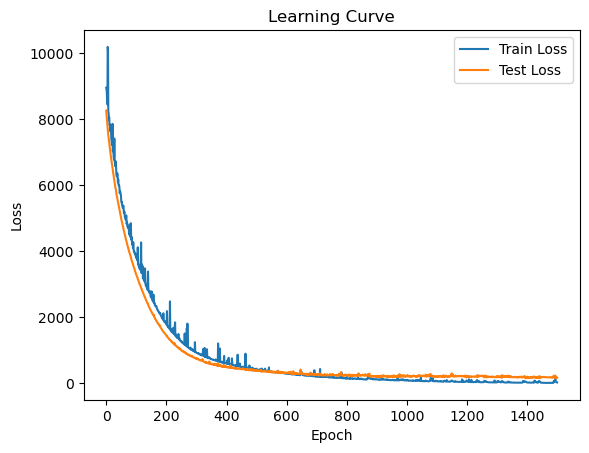

In [145]:
train_size = int(0.7 * len(dataset1))
test_size = len(dataset1) - train_size
train_dataset, test_dataset = random_split(dataset1, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# Model Configuration
input_size = 3  # Alpha, Lambda, and Y
hidden_size = 128#128#64
output_seq_len = 35  # Predict y6 to y40
num_layers = 2#3#2
model1 = LSTMEncoderDecoder(input_size, hidden_size, output_seq_len, num_layers).to(device)
# Training the Model
train_losses, test_losses = train_model(model1, train_loader, test_loader, num_epochs=1500, teacher_forcing_ratio=0.5)
# Plotting Results
plot_learning_curve(train_losses, test_losses)


In [153]:
predictions1=[]
yy_test1=[]
model2.eval()
with torch.no_grad():
    for input_seq, target_seq in test_loader:
        output = model1(input_seq)
        predictions1.append(output[0, :, 2])
        yy_test1.append(target_seq[0, :, 2])
evalution2(yy_test1,predictions1)

mae 7.649497735369336
rmse 11.16238240399998


In [155]:
mae, rmse = [], []
for y_t, x_t in zip(yy_test1, predictions1):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,7.649498,6.492829,1.650595,3.341065,5.341559,7.826098,22.609041


In [157]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,19.932201,16.522562,4.010856,8.062908,13.389041,20.541258,56.29882


Epoch 1/2000, Train Loss: 69900.4233, Test Loss: 69306.4482
Epoch 2/2000, Train Loss: 72766.9859, Test Loss: 69009.6127
Epoch 3/2000, Train Loss: 69593.3719, Test Loss: 68758.2755
Epoch 4/2000, Train Loss: 71195.2209, Test Loss: 68467.7109
Epoch 5/2000, Train Loss: 69875.8985, Test Loss: 68215.4278
Epoch 6/2000, Train Loss: 67211.4611, Test Loss: 67960.3703
Epoch 7/2000, Train Loss: 68043.3273, Test Loss: 67727.0682
Epoch 8/2000, Train Loss: 66629.4535, Test Loss: 67507.4450
Epoch 9/2000, Train Loss: 66331.7791, Test Loss: 67265.9280
Epoch 10/2000, Train Loss: 70463.9554, Test Loss: 67050.7788
Epoch 11/2000, Train Loss: 66665.2216, Test Loss: 66827.8468
Epoch 12/2000, Train Loss: 66297.0198, Test Loss: 66617.3293
Epoch 13/2000, Train Loss: 69934.0379, Test Loss: 66396.1381
Epoch 14/2000, Train Loss: 65331.7474, Test Loss: 66196.1091
Epoch 15/2000, Train Loss: 65361.2244, Test Loss: 65972.8298
Epoch 16/2000, Train Loss: 64777.6199, Test Loss: 65767.8550
Epoch 17/2000, Train Loss: 68890.

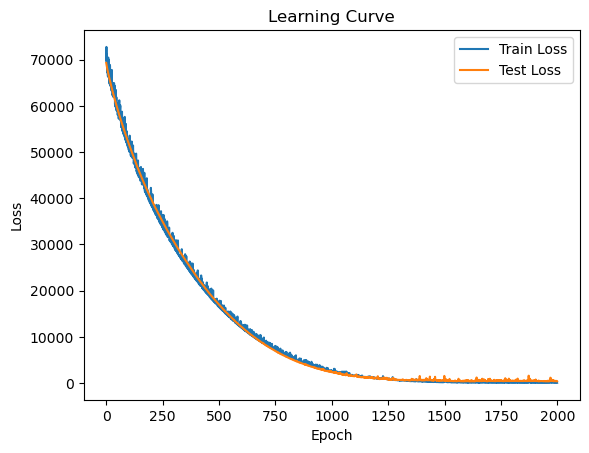

In [183]:
#+4
def create_sequences_from_dataframe4(df):
    sequences = []
    for i in range(len(df)):
        row = df.iloc[i]
        # Extract y1...y40
        y_values = row.loc[1:40].values
        alpha = row["alpha"]
        lambda_ = row["lmbd"]
        
        # Create input sequence (5 timesteps, 3 features)
        input_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(4)
        ])
        target_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(4,40)
        ])        
        # Create target sequence (35 timesteps, 1 feature)
        #target_seq = y_values[5:].reshape(-1, 1)
        
        sequences.append((input_seq, target_seq))
    return sequences

# Create Dataset
sequences = create_sequences_from_dataframe4(df)

# Convert to PyTorch Dataset
class MyDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq, target_seq = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

# Initialize Dataset
dataset1 = MyDataset(sequences)
train_size = int(0.7 * len(dataset1))
test_size = len(dataset1) - train_size
train_dataset, test_dataset = random_split(dataset1, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# Model Configuration
input_size = 3  # Alpha, Lambda, and Y
hidden_size = 128#128#64
output_seq_len = 36  # Predict y6 to y40
num_layers = 2#3#2
model2 = LSTMEncoderDecoder(input_size, hidden_size, output_seq_len, num_layers).to(device)
# Training the Model
train_losses, test_losses = train_model(model2, train_loader, test_loader, num_epochs=2000, teacher_forcing_ratio=0.5)
# Plotting Results
plot_learning_curve(train_losses, test_losses)


In [184]:
predictions2=[]
yy_test2=[]
model2.eval()
with torch.no_grad():
    for input_seq, target_seq in test_loader:
        output = model2(input_seq)
        predictions2.append(output[0, :, 2])
        yy_test2.append(target_seq[0, :, 2])
evalution2(yy_test2,predictions2)

mae 11.368249803526787
rmse 15.735457035445727


In [185]:
mae, rmse = [], []
for y_t, x_t in zip(yy_test2, predictions2):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,11.36825,6.650374,3.626202,5.634562,12.399915,14.993751,24.951714


In [186]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,28.668386,20.372225,6.91699,10.867727,25.642235,41.486835,67.623856


Epoch 1/1500, Train Loss: 64503.8662, Test Loss: 75034.1232
Epoch 2/1500, Train Loss: 65280.8883, Test Loss: 74706.9748
Epoch 3/1500, Train Loss: 64104.1887, Test Loss: 74426.9579
Epoch 4/1500, Train Loss: 66598.9681, Test Loss: 74173.1208
Epoch 5/1500, Train Loss: 65680.2328, Test Loss: 73937.0159
Epoch 6/1500, Train Loss: 63423.8798, Test Loss: 73716.5081
Epoch 7/1500, Train Loss: 67175.0932, Test Loss: 73516.3666
Epoch 8/1500, Train Loss: 62658.9298, Test Loss: 73325.4150
Epoch 9/1500, Train Loss: 63446.7968, Test Loss: 73154.0562
Epoch 10/1500, Train Loss: 62986.8624, Test Loss: 72995.3200
Epoch 11/1500, Train Loss: 66680.5216, Test Loss: 72839.6373
Epoch 12/1500, Train Loss: 65151.9370, Test Loss: 72690.2629
Epoch 13/1500, Train Loss: 62931.3008, Test Loss: 72558.3257
Epoch 14/1500, Train Loss: 63504.4870, Test Loss: 71896.4925
Epoch 15/1500, Train Loss: 62405.0500, Test Loss: 71606.4360
Epoch 16/1500, Train Loss: 61189.3804, Test Loss: 71331.5910
Epoch 17/1500, Train Loss: 61761.

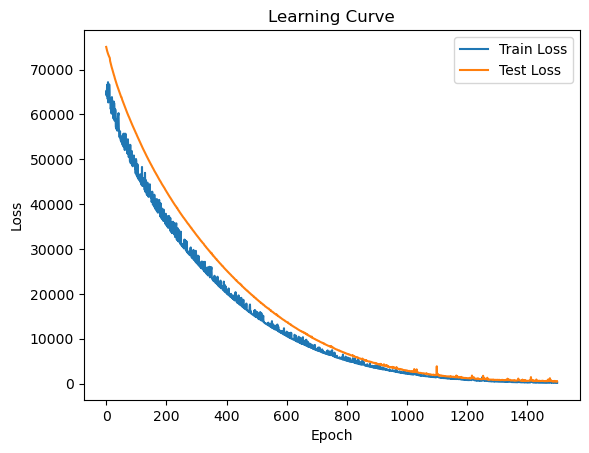

In [163]:
def create_sequences_from_dataframe3(df):
    sequences = []
    for i in range(len(df)):
        row = df.iloc[i]
        # Extract y1...y40
        y_values = row.loc[1:40].values
        alpha = row["alpha"]
        lambda_ = row["lmbd"]
        
        # Create input sequence (5 timesteps, 3 features)
        input_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(3)
        ])
        target_seq = np.array([
            [ alpha, lambda_,y_values[t]] for t in range(3,40)
        ])        
        # Create target sequence (35 timesteps, 1 feature)
        #target_seq = y_values[5:].reshape(-1, 1)
        
        sequences.append((input_seq, target_seq))
    return sequences

# Create Dataset
sequences = create_sequences_from_dataframe3(df)

# Convert to PyTorch Dataset
class MyDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq, target_seq = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

# Initialize Dataset
dataset1 = MyDataset(sequences)
train_size = int(0.7 * len(dataset1))
test_size = len(dataset1) - train_size
train_dataset, test_dataset = random_split(dataset1, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# Model Configuration
input_size = 3  # Alpha, Lambda, and Y
hidden_size = 128#128#64
output_seq_len = 37  # Predict y6 to y40
num_layers = 2#3#2
model3 = LSTMEncoderDecoder(input_size, hidden_size, output_seq_len, num_layers).to(device)
# Training the Model
train_losses, test_losses = train_model(model3, train_loader, test_loader, num_epochs=1500, teacher_forcing_ratio=0.5)
# Plotting Results
plot_learning_curve(train_losses, test_losses)


In [164]:
predictions3=[]
yy_test3=[]
model3.eval()
with torch.no_grad():
    for input_seq, target_seq in test_loader:
        output = model3(input_seq)
        predictions3.append(output[0, :, 2])
        yy_test3.append(target_seq[0, :, 2])
evalution2(yy_test3,predictions3)

mae 9.394611461742505
rmse 12.798641424162321


In [165]:
mae, rmse = [], []
for y_t, x_t in zip(yy_test3, predictions3):
    mae.append(mean_absolute_error(y_t, x_t))
    rmse.append(root_mean_squared_error(y_t, x_t))
df_describe = pd.DataFrame(mae)
df_describe = df_describe.describe().T
df_describe.index = ['mae']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
mae,9.394612,5.630758,3.055055,6.3736,8.10048,12.129179,23.559628


In [166]:
df_describe = pd.DataFrame(rmse)
df_describe = df_describe.describe().T
df_describe.index = ['rmse']
df_describe.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
rmse,23.602823,18.023098,5.624339,13.052947,18.674141,32.468098,74.987122


In [191]:
torch.save(model3, 'model3')
torch.save(model1, 'model5')
torch.save(model2, 'model4')